<a href="https://colab.research.google.com/github/kaneelgit/msi_voxceleb/blob/main/Model_comparisons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font size = '6'> <center>**Model Comparison**</center></font>

Here I am combining the two models based on bayesian cue combination. I use the trained video and audio models and will be combining them based on the precision of each data source. Here I will be assuming that both audio and video data are 100% precise for simplicity. Then I will be compairing the three model performances in the end. 

VoxCeleb dataset - https://www.robots.ox.ac.uk/~vgg/data/voxceleb/

In [ ]:
#import libraries
from urllib.request import urlopen
from zipfile import ZipFile

from IPython.display import HTML
from base64 import b64encode
import matplotlib.pyplot as plt

import os
import glob
import numpy as np
import pandas as pd
import cv2     # for capturing videos
import math
import random

import moviepy.editor as mp
from IPython.display import clear_output

import IPython
import librosa

from scipy.io import wavfile
import os
import tensorflow as tf

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2260992/45929032 bytes (4.9%)5480448/45929032 bytes (11.9%)8486912/45929032 bytes (18.5%)11870208/45929032 bytes (25.8%)15425536/45929032 bytes (33.6%)18841600/45929032 bytes (41.0%)22339584/45929032 bytes (48.6%)25632768/45929032 bytes (55.8%)28614656/45929032 bytes (62.3%)31907840/45929032 bytes (69.5%)35160064/45929032 bytes (76.6%)38363136/45929032 bytes (83.5%)

# **Download and unzip the data**

In [ ]:
#get url
!wget "https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip"

--2021-10-31 13:32:08--  https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox2_test_mp4.zip
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8906971319 (8.3G) [application/zip]
Saving to: ‘vox2_test_mp4.zip’

vox2_test_mp4.zip   100%[===================>]   8.29G  11.8MB/s    in 12m 36s 

2021-10-31 13:44:45 (11.2 MB/s) - ‘vox2_test_mp4.zip’ saved [8906971319/8906971319]



In [ ]:
!unzip vox2_test_mp4.zip

# **Organizing the data**

In the cells below I am collecting all the video paths in a list. I will be then using these videos to extract the audios and their spectrograms to feed in to the neural network.

In [ ]:
#get video paths
vid_paths = []

for path, directories, files in os.walk('/content/mp4/'):

  for file in files:

    vid_paths.append(str(path) + '/' + str(file))

#number of videos available
print('Number of videos available: ', len(vid_paths))

#shuffle video paths. I have used a random seed of 4 to shuffle.
random.seed(10)
random.shuffle(vid_paths)

Number of videos available:  36237


# **Upload the CSV file and clean meta data**


The csv file with meta data is in my github repository. (https://github.com/kaneelgit/msi_voxceleb). You have to upload the csv file to colab before running the following cells.

In [ ]:
#some functions to clean the csv file
#del spaces from the ids and gender
def del_spaces(string):
  
  string = string.replace(' ', '')

  return string

#upload csv file from github before running
#open csv file
df = pd.read_csv('/content/vox2_meta.csv')
df.head(5)

#clean the dataset

#apply the function to get rid of spaces
df['VoxCeleb2 ID'] = df['VoxCeleb2 ID'].apply(del_spaces)
df['VGGFace2 ID'] = df['VGGFace2 ID'].apply(del_spaces)
df['Gender'] = df['Gender'].apply(del_spaces)
df['Set'] = df['Set'].apply(del_spaces)


#get the test data
df2 = df[df['Set'] == 'test']
df2['Gender'] = df2['Gender'].astype('category')

df2.head(5)

,VoxCeleb2 ID,VGGFace2 ID,Gender,Set
3,id00017,n000017,m,test
36,id00061,n000061,m,test
53,id00081,n000081,m,test
89,id00154,n000154,m,test
271,id00419,n000419,f,test


# **Create a Labels List**

Here I am going through the ids of all the video files and picking the gender from the CSV file. Note that there are double the size of male videos compared to female. So I will be taking every other video file to balance the dataset.

In [ ]:
#iterate through the vid_paths get the id of the person and get if the person is female or male. If the person is male its a 1 and female its a 0
labels = []

#get only half of the male videos.
count = 0
video_files = []

#iterate
for path in vid_paths:
  
  #get id number
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  if gender == 'm':
    if count % 2 == 0:
      labels.append(1)
      video_files.append(path)
    count += 1
  
  else:
    labels.append(0)
    video_files.append(path)

In [ ]:
def convert_data(path):

  #get label
  id_str =  path[13:20]

  #get if the subject is male or female from the csv
  gender = df2.loc[df2['VoxCeleb2 ID'] == str(id_str)]['Gender'].values[0]

  label = 1 if gender == 'm' else 0

  #video processing
  video = mp.VideoFileClip(path).subclip(0, 3)

  #imag
  imag = video.get_frame(0)/255

  #audio processing
  audio = video.audio.to_soundarray()

  #sampling rate
  fs = 44100
  
  #channel 1
  ch1 = librosa.feature.melspectrogram(audio[:, 0], sr = fs)
  mel_ch1 = librosa.amplitude_to_db(ch1, ref = np.min)

  return imag, mel_ch1.reshape(mel_ch1.shape[0], mel_ch1.shape[1], 1), label

# **Compairing Models**

First I will recreate the audio and video model architectures since I only saved the weights of each model.  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Average, Activation, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.keras.utils.vis_utils import plot_model



In [ ]:
#Audio Model
def aud_model(x):
    
    inputs = x
    x = tf.keras.layers.Conv2D(16, kernel_size = (3, 3),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
   
    return x

#input
input_samp = np.zeros([16, 128, 259, 1])

#input
input = Input(input_samp[0, :].shape, name = 'audio')
out = aud_model(input)
out = Flatten()(out)
out = Dropout(0.5)(out)
out = Dense(1024, activation = 'relu')(out)
out = Dropout(0.8)(out)
out = Dense(128, activation = 'relu')(out)
output = Dense(1, activation = 'sigmoid', name = 'class')(out)

#create the model
audio_model = Model(input, output)
audio_model.load_weights('audition.h5')

In [ ]:
#Video Model
def vid_model(x):
    
    inputs = x
    x = tf.keras.layers.Conv2D(16, kernel_size = (3, 3),activation = 'relu')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(32, kernel_size = (3, 3), activation = 'relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)
    
    x = tf.keras.layers.Conv2D(64, kernel_size = (6, 6), activation = 'relu')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2))(x)

    return x

#input
input_samp = np.zeros([16, 224, 224, 3])

#input
input = Input(input_samp[0, :].shape, name = 'video')
out = vid_model(input)
out = Flatten()(out)
out = Dropout(0.5)(out)
out = Dense(1024, activation = 'relu')(out)
out = Dense(128, activation = 'relu')(out)
output = Dense(1, activation = 'sigmoid', name = 'class')(out)

#create the model
video_model = Model(input, output)
video_model.load_weights('vision.h5')

## **Functions that predict if male or female given data**

Here I am creating three functions (audio, video and bimodal) that predicts if the given data is of a female or a male. 

For the bimodal prediction, I will be using the bayesian cue combination model. I will be weighting the video and audio data by it's precision. The default precision value is set to 1. In this case I will be using precisions for both video and audio data to be 1. In other words I am assuming that data by both sources are 100% precise. So the bimodal prediction in this case will be just the average of the video and audio prediction. 

In [ ]:
#create audio only video only and multimodel prediction functions
def aud_pred(aud_array):
  #reshape the audio array
  aud_array = aud_array.reshape(1, aud_array.shape[0], aud_array.shape[1], aud_array.shape[2])
  #calculate the prediction
  pred = audio_model.predict(aud_array)[0][0]

  return 1 if pred >= 0.5 else 0

def vid_pred(vid_array):
  #reshape the video array
  vid_array = vid_array.reshape(1, vid_array.shape[0], vid_array.shape[1], vid_array.shape[2])
  #calculate the prediction
  pred = video_model.predict(vid_array)[0][0]

  return 1 if pred >= 0.5 else 0

def bimod_pred(vid_array, aud_array, vid_prec = 1, aud_prec = 1):
  #reshape arrays
  aud_array = aud_array.reshape(1, aud_array.shape[0], aud_array.shape[1], aud_array.shape[2])
  vid_array = vid_array.reshape(1, vid_array.shape[0], vid_array.shape[1], vid_array.shape[2])

  #predictions
  aud_pred = audio_model.predict(aud_array)[0][0]

  #video prediction
  vid_pred = video_model.predict(vid_array)[0][0]

  #calculate bimodal outcome
  bimod_pred = vid_prec/(aud_prec + vid_prec) * vid_pred + aud_prec/(aud_prec + vid_prec) * aud_pred

  return 1 if bimod_pred >= 0.5 else 0


## **Calculate accuracies of the three Models**

In [ ]:
#get data
random_idx = np.random.choice(np.arange(0, len(video_files)), 1000)

#Convert these to 10 batches
batches = [random_idx[i : i + 100] for i in range(0, len(random_idx), 100)]


In [ ]:
#calculate the accuracies
vid_acc = []
aud_acc = []
bimod_acc = []

for batch in batches:
  #arrays for each batch data 
  vid = []
  aud = []
  bimod = []

  for idx in batch:
    
    #get path
    path = video_files[idx]

    #get image, audio and label
    img, audio, label = convert_data(path)
    
    #make predictions
    vid_prediction = vid_pred(img)
    aud_prediction = aud_pred(audio)
    bimod_prediction = bimod_pred(img, audio)

    #collect data
    vid.append(1 if vid_prediction == label else 0)
    aud.append(1 if aud_prediction == label else 0)
    bimod.append(1 if bimod_prediction == label else 0)

  #calculate the accuracies
  video_batch_acc = np.sum(vid)/len(vid)
  audio_batch_acc = np.sum(aud)/len(aud)
  bimod_batch_acc = np.sum(bimod)/len(bimod)

  #append data
  vid_acc.append(video_batch_acc)
  aud_acc.append(audio_batch_acc)
  bimod_acc.append(bimod_batch_acc)


# **Plotting results**

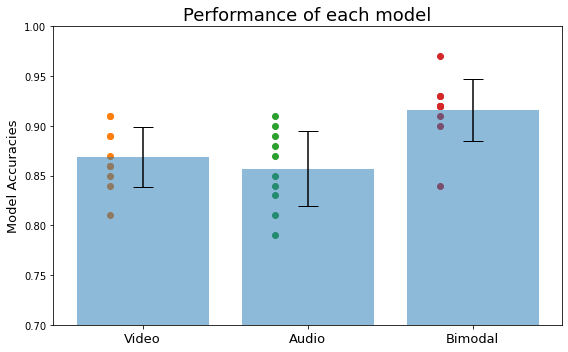

In [ ]:
#bar plot with accuracies
#means
video_mean = np.mean(vid_acc)
audio_mean = np.mean(aud_acc)
bimod_mean = np.mean(bimod_acc)

#std
video_std = np.std(vid_acc)
audio_std = np.std(aud_acc)
bimod_std = np.std(bimod_acc)

#data
models = ['Video', 'Audio', 'Bimodal']
x_pos = np.arange(len(models))
mod_means = [video_mean, audio_mean, bimod_mean]
mod_errors = [video_std, audio_std, bimod_std]

#figure
fig, ax = plt.subplots(figsize = (8, 5))
ax.bar(x_pos, mod_means, yerr = mod_errors, align = 'center', alpha = 0.5, ecolor = 'black', capsize = 10)
ax.scatter(np.zeros(len(vid_acc))- 0.2, vid_acc)
ax.scatter(np.ones(len(aud_acc))- 0.2, aud_acc)
ax.scatter(np.ones(len(bimod_acc))*2 - 0.2, bimod_acc)
ax.set_ylabel('Model Accuracies', fontsize =  13)
ax.set_ylim([0.7, 1])
ax.set_xticks(x_pos)
ax.set_xticklabels(models, fontsize = 13)
ax.set_title('Performance of each model', fontsize = 18)

plt.tight_layout()
plt.show()